In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../dataset/NewYork_365.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute

# Create time-based features
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
# Assume you have a predefined list of holidays
holidays = pd.to_datetime(['2024-01-01', '2024-12-25'])  # Example holidays
df['Is_Holiday'] = df['Date'].apply(lambda x: 1 if x in holidays else 0)

In [6]:
df = df.drop(columns=['Hour', 'Minute']).reset_index(drop=True)

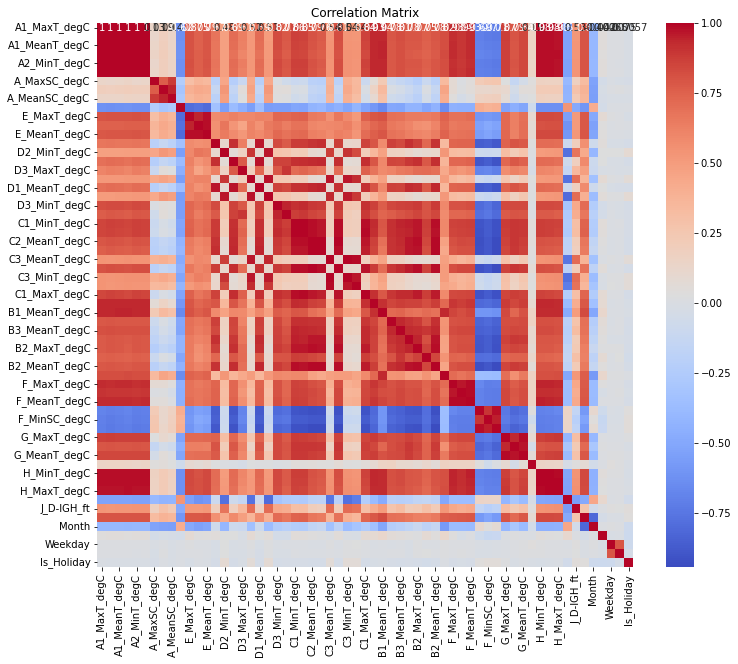

In [7]:
correlation_matrix = df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Ensemble Model for feature selection

In [8]:
ndf = df.drop(columns=['Date']).reset_index(drop=True)

In [9]:
# daily instantaneous Gage height is target as it is the level of basin depth

features = ndf.drop(columns=['J_D-IGH_ft'])  
target = ndf['J_D-IGH_ft'] 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3.8635135135122126e-05


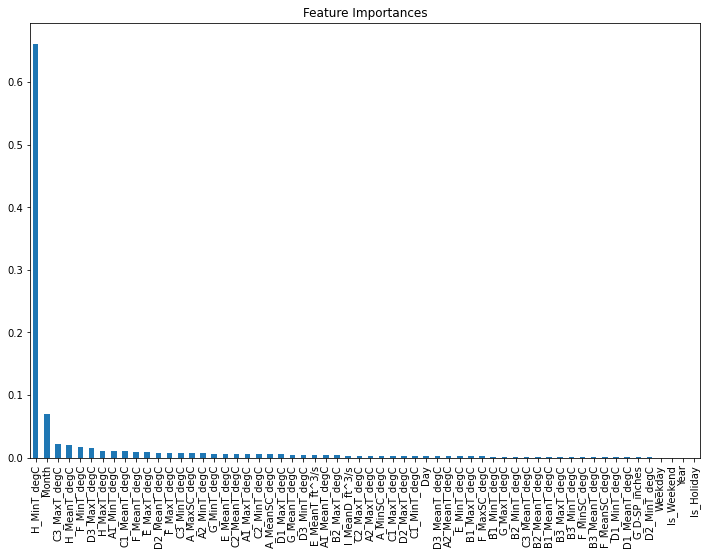

Important features based on Random Forest:
H_MinT_degC       6.613711e-01
Month             6.972612e-02
C3_MaxT_degC      2.239224e-02
H_MeanT_degC      1.974742e-02
F_MinT_degC       1.740590e-02
D3_MaxT_degC      1.579664e-02
H_MaxT_degC       1.041183e-02
A1_MinT_degC      1.025257e-02
C1_MeanT_degC     1.013457e-02
F_MeanT_degC      9.802438e-03
E_MaxT_degC       8.716067e-03
D2_MeanT_degC     7.668481e-03
F_MaxT_degC       7.371595e-03
C3_MinT_degC      7.140244e-03
A_MaxSC_degC      6.899924e-03
A2_MinT_degC      6.675761e-03
G_MinT_degC       6.078782e-03
E_MeanT_degC      5.697303e-03
C2_MeanT_degC     5.650771e-03
A1_MaxT_degC      5.563427e-03
C2_MinT_degC      5.471506e-03
A_MeanSC_degC     5.180477e-03
D1_MaxT_degC      5.075221e-03
G_MeanT_degC      4.977380e-03
D3_MinT_degC      4.496394e-03
E_MeanT_ft^3/s    3.927620e-03
A1_MeanT_degC     3.924192e-03
B2_MaxT_degC      3.718741e-03
I_MeanD_ft^3/s    2.966358e-03
C2_MaxT_degC      2.938860e-03
A2_MaxT_degC      2.769976e

In [13]:
# Get feature importances
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

# Display important features
print("Important features based on Random Forest:")
print(feature_importances)

Threshold calculation

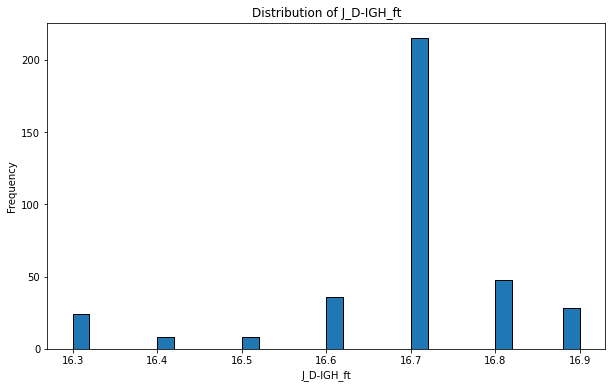

In [14]:
import matplotlib.pyplot as plt

# Plot histogram of J_D-IGH_ft values
plt.figure(figsize=(10, 6))
plt.hist(ndf['J_D-IGH_ft'], bins=30, edgecolor='k')
plt.title('Distribution of J_D-IGH_ft')
plt.xlabel('J_D-IGH_ft')
plt.ylabel('Frequency')
plt.show()


In [25]:
# Calculate percentiles for thresholds
minThreshold = ndf['J_D-IGH_ft'].quantile(0.08)  # 25th percentile
maxThreshold = ndf['J_D-IGH_ft'].quantile(0.92)  # 75th percentile

print(f"minThreshold: {minThreshold}")
print(f"maxThreshold: {maxThreshold}")


minThreshold: 16.4
maxThreshold: 16.8


In [26]:
# Define flood severity based on thresholds
def classify_severity(value, minT, maxT):
    if value < minT:
        return 'Low'
    elif minT <= value < maxT:
        return 'Moderate'
    else:
        return 'High'

# Apply classification
ndf['Flood_Severity'] = ndf['J_D-IGH_ft'].apply(lambda x: classify_severity(x, minThreshold, maxThreshold))

# Display the updated DataFrame
print(ndf[['J_D-IGH_ft', 'Flood_Severity']])


     J_D-IGH_ft Flood_Severity
0          16.3            Low
1          16.3            Low
2          16.3            Low
3          16.3            Low
4          16.3            Low
..          ...            ...
362        16.7       Moderate
363        16.7       Moderate
364        16.7       Moderate
365        16.7       Moderate
366        16.7       Moderate

[367 rows x 2 columns]


MOdel 

TBA + RF Classifier

In [17]:
# def calculate_features(A_GH_ft, A_GHTW_ft, B1_D_SP_inches, df):
#     # Calculate rolling mean
#     A_GH_ft_Rolling_Mean_3 = df['A_GH_ft'].rolling(window=3).mean().iloc[-1]

#     # Calculate lag feature
#     A_GH_ft_Lag1 = df['A_GH_ft'].shift(1).iloc[-1]

#     # Calculate interaction term
#     A_GHTW_ft_B1_D_SP_inches_Interaction = A_GHTW_ft * B1_D_SP_inches
    
#     return A_GH_ft_Rolling_Mean_3, A_GH_ft_Lag1, A_GHTW_ft_B1_D_SP_inches_Interaction

In [28]:
from sklearn.metrics import accuracy_score

X = ndf[['H_MinT_degC', 'C3_MaxT_degC', 'H_MeanT_degC']]
y = ndf['Flood_Severity']

In [29]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
NYModel = RandomForestClassifier(n_estimators=100, random_state=42)
NYModel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
user_H_MinT = 25.5   # 8.5 -25.5
user_C3_MaxT = 22.7  # 14 - 22.7
user_H_MeanT = 26  # 9 - 26

# Prepare input for prediction
input_features = pd.DataFrame([[user_H_MinT,user_C3_MaxT,user_H_MeanT ]], columns=['H_MinT_degC', 'C3_MaxT_degC', 'H_MeanT_degC'])

# Predict flood severity
flood_severity = NYModel.predict(input_features)
print(f"Predicted Flood Severity: {flood_severity[0]}")

Predicted Flood Severity: Moderate


In [32]:
import joblib

joblib.dump(NYModel, '../ny_model.pkl')

['../ny_model.pkl']